In [1]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np                    #
from fenics import *                  # imports the fenics package
import os                             # allows to use path
import time                           # allows to measure real time
import pandas as pd                   # allows to manage with numerical data

In [2]:
# Path settings
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output20"
os.makedirs(out_path, exist_ok=True)

In [3]:
# Time dimension parameters
t_0 = 0            # initial time
T = 1.0            # final time
num_steps = 10     # number of time steps
dt = (T-t_0) / num_steps # time step size

In [4]:
# Create mesh
length = 5
thickness = 5
height = 5
nelements = 20

mesh = BoxMesh(Point(-length/2, -thickness/2, -height/2), Point(length/2, thickness/2, height/2), nelements, nelements, nelements)
mesh

In [5]:
# Define a function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [6]:
# Create class that defines subdomains for bondaries conditions (inherits from fenics.SubDomain)
class LowerSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], -height/2, tol)
    
class UpperSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], height/2, tol)

In [7]:
# Mark facets and save the result in .pvd file
domains_facets  = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1)
domains_facets.set_all(0)

# Mark bottom facets
bottom = LowerSide()
bottom.mark(domains_facets, 1)

# Mark upper facets
up = UpperSide()
up.mark(domains_facets, 2)

# Save in .pvd file
boundaries_file = File(os.path.join(out_path, "boundaries.pvd"))
boundaries_file << domains_facets

In [8]:
# Integration over subdomains
ds = Measure('ds', domain=mesh, subdomain_data=domains_facets)

# Constant 3D vector
f = Constant((0,0,1))
# Surface normals of the cube
n = FacetNormal(mesh)

print("Integral over entire surface:      ", assemble(inner(f,n)*ds) )
print("Integral over lower surface only:   ", assemble(inner(f,n)*ds(1)) )
print("Integral over upper surface only:   ", assemble(inner(f,n)*ds(2)) )

Integral over entire surface:       0.0
Integral over lower surface only:    -25.0
Integral over upper surface only:    25.0


In [9]:
# Boundary conditions
u_0 = Constant((0,0,0))          # No displacement
u_t = Expression(('0','0','1*t'), degree=1, t=0)          # Traction
u_c = Expression(('0','0','-1*t'), degree=1, t=0)         # Compression
u_s = Expression(('1*t','0','0'), degree=1, t=0)          # Shearing

u_1 = u_t                        # Define displacement on upper part (type of test)

# Define initial value
u_n = interpolate(u_1, V)

# Define bc as u_0 in the vector space V on the subdomain domains_facets labeled by 1 (lower facets)
bcl = DirichletBC(V, u_0, domains_facets, 1)
bcu = DirichletBC(V, u_1, domains_facets, 2)
bcs = [bcl, bcu]

In [10]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

In [11]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                  # Identity tensor
F = I + grad(u)                  # Deformation gradient
F = variable(F)                  # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation
C = F.T*F                        # Right Cauchy-Green tensor

In [12]:
# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

In [13]:
# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

In [14]:
# Stored strain energy density (modified one-term Ogden model)
#psi = 2 * mu * [lmbda1^alpha + lmbda2^alpha + lmbda3^alpha - 3] / alpha^2
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

In [15]:
# Total potential energy
Pi = psi*dx                                      # without traction force

In [16]:
# Compute first variation of Pi (directional derivative about u in the direction of v)
Fpi = derivative(Pi, u, v)

In [17]:
# Compute Jacobian of Fpi
J = derivative(Fpi, u, du)

In [18]:
# Create XMDF file for the solution
results = xdmffile = XDMFFile(os.path.join(out_path, 'results.xdmf'))
results.parameters["flush_output"] = True
results.parameters["functions_share_mesh"] = True

In [19]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [20]:
# Define the solver
problem = NonlinearVariationalProblem(Fpi, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'cg'
prm['newton_solver']['preconditioner'] = 'icc'

#prm['newton_solver']['error_on_nonconvergence'] = True
#prm['newton_solver']['absolute_tolerance'] = 1E-9
#prm['newton_solver']['relative_tolerance'] = 1E-8
#prm['newton_solver']['maximum_iterations'] = 25
#prm['newton_solver']['relaxation_parameter'] = 1.0

#prm['newton_solver']['lu_solver']['report'] = True
#prm['newton_solver']['lu_solver']['reuse_factorization'] = False
#prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = False
#prm['newton_solver']['lu_solver']['symmetric'] = False

#prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = True
#prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
#prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-5
#prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
#prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
#if prm['newton_solver']['linear_solver'] == 'gmres':
#    prm['newton_solver']['preconditioner'] = 'ilu'

In [21]:
# Time-stepping
t = t_0
Atime = []
Stime = []
Rf_lo = []
Rf_up = []

for i in range(num_steps+1):
    
    print("Actual time:   ", t , "s")

    # Update current time
    Atime.append(t)
    u_1.t = t

    # Compute solution
    tic = time.clock()
    #solve(Fpi == 0, u, bcs, J=J)
    #solve(Fpi == 0, u, bcs, J=J, form_compiler_parameters=ffc_options)       # solve using optimization options
    solver.solve()
    toc = time.clock()
    
    # Save solving time in an array
    Stime.append(toc-tic)
    
    # compute max / min displacement
    W = FunctionSpace(mesh, 'P', 1)

    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, W)
    print('Min/Max displacement:',
          u_magnitude.vector().get_local().min(),
          u_magnitude.vector().get_local().max())

    # Computation of the stresses
    Z = TensorFunctionSpace(mesh, 'P', 1)
    print("Stress derivation and saving to file")
    S = diff(psi, F)            # compute material stress by differentiation of psi!
    S_project = project(S, Z, solver_type='cg')
    S_project.rename("Material stress (MPa)", "")
    
    # Computation of van Mises Stress
    s = S - (1./3) * tr(S) * Identity(u.geometric_dimension())     # compute the stress deviator
    von_Mises = sqrt( 3./2 * inner(s, s) )
    von_Mises_project = project(von_Mises, W)
    von_Mises_project.rename("Von Mises stress (MPa)", "")
    print("Maximum equivalent stress:", von_Mises_project.vector().get_local().max())
    
    # Computation of reaction forces
    T = inv(det(F)) * F * S * F.T                     # Cauchy stress tensor
    T_project = project(T, Z, solver_type='cg')
    T_project.rename("Spatial stress (MPa)", "")
    tn = dot(T,n)                                     # Cauchy stress vectors
    Rf_lo.append(assemble(inner(tn,n)*ds(1)))        # normal reaction force on lower surface
    Rf_up.append(assemble(inner(tn,n)*ds(2)))        # normal reaction force on upper surface
    
    # Save results in XMDF format 
    u.rename("Displacement field (mm)","")
    results.write(u,t)
    results.write(S_project,t)
    results.write(von_Mises_project,t)
    results.write(T_project,t)

    # Update previous solution
    u_n.assign(u)
    
    # Update time
    t += dt

Actual time:    0 s
Min/Max displacement: 0.0 0.0
Stress derivation and saving to file
Maximum equivalent stress: 0.0
Actual time:    0.1 s
Min/Max displacement: 4.73163029274e-07 0.100000032853
Stress derivation and saving to file
Maximum equivalent stress: 0.338167981128
Actual time:    0.2 s
Min/Max displacement: 9.42565756386e-07 0.20000006453
Stress derivation and saving to file
Maximum equivalent stress: 0.644658533483
Actual time:    0.30000000000000004 s
Min/Max displacement: 1.40801216431e-06 0.300000095122
Stress derivation and saving to file
Maximum equivalent stress: 0.924479233503
Actual time:    0.4 s
Min/Max displacement: 1.86364741017e-06 0.400000124708
Stress derivation and saving to file
Maximum equivalent stress: 1.18172185952
Actual time:    0.5 s
Min/Max displacement: 2.31088859819e-06 0.500000153358
Stress derivation and saving to file
Maximum equivalent stress: 1.41974498745
Actual time:    0.6 s
Min/Max displacement: 2.75088462766e-06 0.600000181132
Stress deriv

    Solving Time (s)  Time (s)  Reaction Force on base (N)  Reaction Force (N)
0           0.057023       0.0                    0.000000            0.000000
1           1.650337       0.1                    5.629193            5.629193
2           1.605283       0.2                   11.272258           11.272258
3           1.625410       0.3                   16.930624           16.930624
4           1.639799       0.4                   22.605774           22.605774
5           1.624508       0.5                   28.299232           28.299232
6           1.617816       0.6                   34.012551           34.012551
7           1.639668       0.7                   39.747302           39.747302
8           1.631043       0.8                   45.505066           45.505066
9           1.611826       0.9                   51.287429           51.287429
10          1.646099       1.0                   57.095971           57.095971


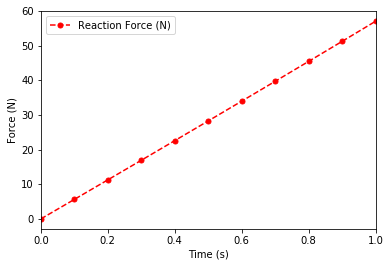

In [22]:
data = {'Solving Time (s)':Stime,
        'Time (s)':Atime,
        'Reaction Force on base (N)':Rf_lo,
        'Reaction Force (N)':Rf_up}
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
print(df)
ax = df.plot(x='Time (s)',y='Reaction Force (N)',color='red',marker='o',markersize=5,linestyle='--')
ax.set_ylabel("Force (N)")
df.to_pickle('Output Data')
plt.savefig('ReactionForce.pdf')